# Deep learning challenge

I'm using the following dataset: https://zenodo.org/records/3384092 and I'm trying to implement a direct reconstruction method similar to TrueFidelity with the help of tensorflow

I did not have any previous experience in deep learning, so i did not manage to implement a working solution that can compete with FBP in time. I will send an updated version soon as I have a more or less acceptable solution. 

## Part 1: Exploratory Data Analysis

In [2]:
import numpy as np

In [3]:
from skimage.transform import radon, iradon, rotate

In [4]:
print(np.__version__)

1.26.4


Unfortunately, tensorflow was not working on windows with my GPU, so I had to set up WSL for it to work. The files are too large to be copied to C, this is why I'm referring them on /mnt/d always

In [5]:
from pathlib import Path
base_path_win = Path('/mnt/d/Masters/Medical_Imaging')

#### first take a look at the ground truth dataset:

In [6]:
import h5py
gtval_path = Path(base_path_win,'gt_train/ground_truth_train_000.hdf5')
file_gt = h5py.File(gtval_path)
print(file_gt.keys())

<KeysViewHDF5 ['data']>


In [7]:
dataset = file_gt['data']
print(dataset.shape)

(128, 362, 362)


[  8.  16.  24.  32.  40.  48.  56.  64.  72.  80.  88.  96. 104. 112.
 120. 128.]
[[  8.  16.  24.  32.]
 [ 40.  48.  56.  64.]
 [ 72.  80.  88.  96.]
 [104. 112. 120. 128.]]


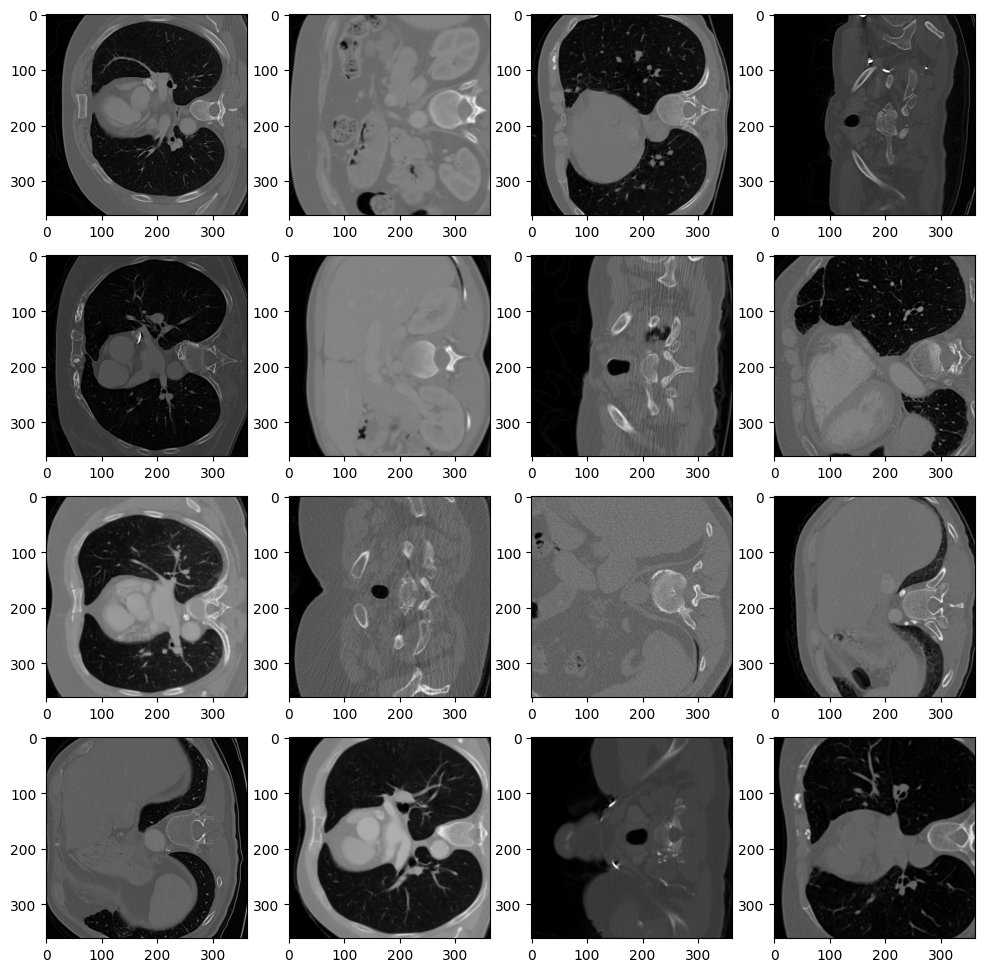

In [8]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 4, figsize = (12, 12))
tocheck = np.linspace(8, 128, 16)
plotarray = np.reshape(tocheck, [4,4])
print(tocheck)
len(tocheck)
print(plotarray)
for i in range(4):
    for j in range(4):
        axs[i, j].imshow(dataset[int(plotarray[i][j])-1][:][:], cmap = 'grey')




In [9]:
file_obs = h5py.File(Path(base_path_win, 'observations_train/observation_train_000.hdf5'))
print(file_obs.keys())

<KeysViewHDF5 ['data']>


In [10]:
dataset_obs = file_obs['data']
print(dataset_obs.shape)

(128, 1000, 513)


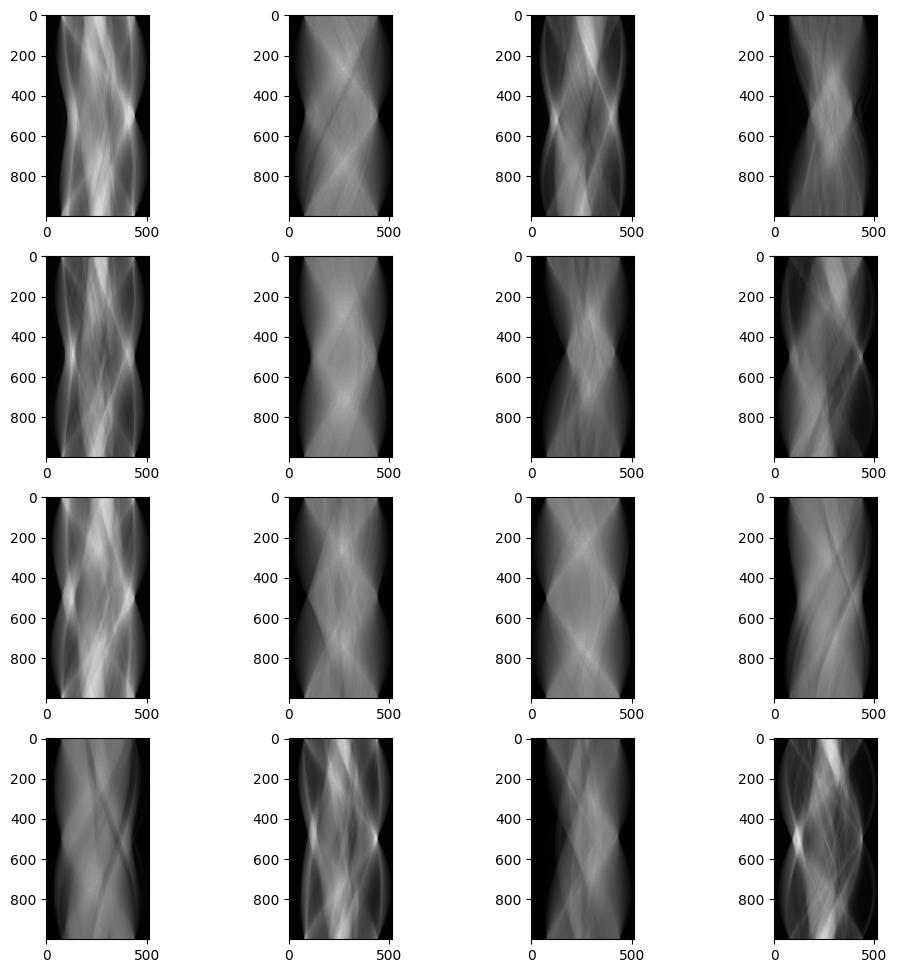

In [11]:
fig, axs = plt.subplots(4, 4, figsize = (12, 12))

for i in range(4):
    for j in range(4):
        axs[i, j].imshow(dataset_obs[int(plotarray[i][j])-1][:][:], cmap = 'grey')

### Conclusion: the ground truth contains the high quality restored images, the observations contain the noisy sinogram. The direct reconstruction algorithm would fit for this gt-observation pair. I'M going to implement it in tensorflow, due to the size of the dataset I have to use gpu support.

In [12]:
import tensorflow as tf
import os
# disable long warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or '3' for less verbose logging

2025-03-17 15:01:17.228432: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-17 15:01:17.228493: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-17 15:01:17.228536: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-17 15:01:17.235636: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
print(tf.reduce_sum(tf.random.normal([1000, 1000])))

tf.Tensor(-74.62775, shape=(), dtype=float32)


2025-03-17 15:01:19.953380: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-17 15:01:19.966875: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-17 15:01:19.967166: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-17 15:01:19.968983: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-17 15:01:19.969343: I tensorflow/compile

These two images
are compared across multiple parameters
such as image noise, low contrast resolution,
low contrast detectability, noise texture, etc.
The output image reports the differences to
the network via backpropagation which then
strengthens some equations and weakens
others and tries again. This process is repeated
till there is accuracy between the output
image and the ground truth image.

In [14]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## Part 2: Load Data

In [15]:
BATCH_SIZE = 1
IMAGE_SIZE = (1000, 513)  # Sinogram size (observation data)
LABEL_SIZE = (362, 362)  # CT image size
NUM_WORKERS = 4  # Number of parallel data loading workers (adjust based on your system)
EPOCHS = 1  # Number of epochs for training

# Paths to HDF5 files
OBSERVATION_DIR = Path(base_path_win, "observations_train")
GROUND_TRUTH_DIR = Path(base_path_win, "gt_train")
VAL_OBS_DIR = Path(base_path_win, "observation_validation")
VAL_GT_DIR = Path(base_path_win, "gt_validation")

In [16]:
# Function to load HDF5 file and prepare batches
def load_hdf5_data(observation_files, ground_truth_files, batch_size):
    while True:
        for obs_file, gt_file in zip(observation_files, ground_truth_files):
            with h5py.File(obs_file, 'r') as obs_f, h5py.File(gt_file, 'r') as gt_f:
                obs_data = np.array(obs_f['data'])  # Shape: (128, 1000, 513)
                gt_data = np.array(gt_f['data'])  # Shape: (128, 362, 362)

                # Ensure both observation and ground truth have the same length
                if len(obs_data) == len(gt_data):
                    # Shuffle data for random sampling
                    indices = np.arange(len(obs_data))
                    obs_data = obs_data[indices]
                    gt_data = gt_data[indices]

                    # Yield batches
                    for i in range(0, len(obs_data), batch_size):
                        obs_batch = obs_data[i:i + batch_size]
                        gt_batch = gt_data[i:i + batch_size]
                        yield obs_batch, gt_batch


In [17]:
def create_dataset(observation_files, ground_truth_files, batch_size):
    dataset = tf.data.Dataset.from_generator(
        lambda: load_hdf5_data(observation_files, ground_truth_files, batch_size),
        output_signature=(
            tf.TensorSpec(shape=(1, *IMAGE_SIZE), dtype=tf.float32),
            tf.TensorSpec(shape=(1, *LABEL_SIZE), dtype=tf.float32)
        )
    )
    # Prefetch data to improve performance
    return dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [18]:
# tf.config.experimental_run_functions_eagerly(True)
# @tf.function
# def custom_loss(y_true, y_pred):
#     # Example of MSE-based custom loss
#     print(tf.shape(y_true))
#     values = y_true.numpy()  # Extract the values as a NumPy array
#     tf.print(values)
#     print(tf.shape(y_pred))
#     values = y_pred.numpy()  # Extract the values as a NumPy array
#     tf.print(values)
#     y_true = tf.expand_dims(y_true, -1)  # Shape becomes [1, 362, 362, 1]
#     y_pred = tf.expand_dims(y_pred, -1)  # Shape becomes [1, 362, 362, 1]
#     mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    
#     # Example of SSIM-based custom loss (lower SSIM means lower similarity)
#     ssim_loss = tf.image.ssim(y_true, y_pred, max_val=1.0)
    
#     # Combine the losses
#     total_loss = 0.5 * mse_loss + 0.5 * ssim_loss
#     return total_loss

## Part 3: Create custom loss function

In [19]:
# I had to set this to true for debugging the custom_loss function

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, regularizers
tf.config.experimental_run_functions_eagerly(False)

import tensorflow.keras.backend as K
@tf.function
def variance_penalty_loss(y_true, y_pred):
    """ 
    Parabolic penalty function for a single image that penalizes both underestimation 
    and overestimation of variance in the predicted image.
    """
    # Compute variance for the entire image
    var_true = 1000*K.var(y_true)  # Variance of true image
    var_pred = 1000*K.var(y_pred)  # Variance of predicted image
    
    # Parabolic penalty: (var_pred - var_true)^2
    loss = K.square(var_true -var_pred)  
    
    return loss

# Load VGG16 model with pre-trained weights (no top layers)
vgg = VGG16(include_top=False, weights='imagenet', input_shape=(362, 362, 3))

# Define the layers to use for feature extraction from VGG16
layer_names = ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3', 'block5_conv3']
layers_to_extract = [vgg.get_layer(name).output for name in layer_names]

# Create a model for feature extraction
feature_extractor = tf.keras.Model(inputs=vgg.input, outputs=layers_to_extract)

# Perceptual loss function
@tf.function
def perceptual_loss(y_true, y_pred):
    # Convert grayscale images to RGB by repeating the grayscale values across 3 channels
    # y_true = tf.squeeze(y_true, axis=0)
    # y_pred = tf.squeeze(y_pred, axis=0)
    # tf.print(y_true.shape)
    # tf.print(y_pred.shape)
    # y_true = tf.expand_dims(y_true, -1)
    # y_pred = tf.expand_dims(y_pred, -1)
    y_true_rgb = tf.image.grayscale_to_rgb(y_true)  # Convert grayscale to RGB
    y_pred_rgb = tf.image.grayscale_to_rgb(y_pred)  # Convert grayscale to RGB
    
    # Extract features from both the true and predicted images using VGG16
    true_features = feature_extractor(y_true_rgb)
    pred_features = feature_extractor(y_pred_rgb)
    
    # Calculate the perceptual loss (L2 loss between features)
    loss = 0
    for true_feat, pred_feat in zip(true_features, pred_features):
        loss += tf.reduce_mean(tf.square(true_feat - pred_feat))  # L2 loss between feature maps
    
    return loss

@tf.function
def frequency_loss(y_true, y_pred):
    # Get image dimensions
    h = tf.shape(y_true)[1]
    w = tf.shape(y_true)[2]
    
    # Compute FFT (native layout: zero-frequency at top-left)
    true_fft = tf.signal.fft2d(tf.cast(y_true, tf.complex64))
    pred_fft = tf.signal.fft2d(tf.cast(y_pred, tf.complex64))
    
    # Create high-pass filter mask in FFT layout
    y = tf.range(tf.cast(h, tf.float32), dtype=tf.float32)  # Explicit cast
    x = tf.range(tf.cast(w, tf.float32), dtype=tf.float32)
    yy, xx = tf.meshgrid(y, x, indexing='ij')  # Shape [h, w]
    
    # Distance from zero-frequency (top-left)
    distance = tf.sqrt(xx**2 + yy**2)
    
    # Cutoff frequency (ensure it's a tensor)
    cutoff = tf.cast(tf.minimum(h, w), tf.float32) / 8.0  # <-- KEY FIX
    
    # Safe boolean mask (all tensors)
    mask = tf.cast(distance > cutoff, tf.complex64)
    
    # Compute loss
    loss = tf.reduce_mean(
        tf.abs(tf.abs(true_fft * mask) - tf.abs(pred_fft * mask))
    )
    return loss

@tf.function
def gradient_loss(y_true, y_pred):
    # Compute Sobel edges (x and y directions)
    true_gradients = tf.image.sobel_edges(y_true)  # Shape: [batch, H, W, 2]
    pred_gradients = tf.image.sobel_edges(y_pred)
    
    # Split into x and y components
    true_dx, true_dy = true_gradients[..., 0], true_gradients[..., 1]
    pred_dx, pred_dy = pred_gradients[..., 0], pred_gradients[..., 1]
    
    # L1 loss on gradients (use L2 for smoother edges)
    loss_x = tf.reduce_mean(tf.abs(true_dx - pred_dx))
    loss_y = tf.reduce_mean(tf.abs(true_dy - pred_dy))
    return loss_x + loss_y

@tf.function
def ssim_loss(y_true, y_pred):
    ssim_loss = 1 - tf.image.ssim(y_true, y_pred, max_val=1.0)
    return ssim_loss

@tf.function
def perc_solo(y_true, y_pred):
    # Convert grayscale images to RGB by repeating the grayscale values across 3 channels

    y_true = tf.expand_dims(y_true, -1)
    y_pred = tf.expand_dims(y_pred, -1)
    y_true_rgb = tf.image.grayscale_to_rgb(y_true)  # Convert grayscale to RGB
    y_pred_rgb = tf.image.grayscale_to_rgb(y_pred)  # Convert grayscale to RGB
    
    # Extract features from both the true and predicted images using VGG16
    true_features = feature_extractor(y_true_rgb)
    pred_features = feature_extractor(y_pred_rgb)
    
    # Calculate the perceptual loss (L2 loss between features)
    loss = 0
    for true_feat, pred_feat in zip(true_features, pred_features):
        loss += tf.reduce_mean(tf.square(true_feat - pred_feat))  # L2 loss between feature maps
    
    return loss

def normalize_image(image):
    mean = tf.reduce_mean(image, axis=[1, 2], keepdims=True)  # Mean per image
    variance = tf.reduce_mean(tf.square(image - mean), axis=[1, 2], keepdims=True)  # Variance per image
    return (image - mean) / tf.sqrt(variance + 1e-7)  # Normalize

@tf.function
def custom_loss(y_true, y_pred):
    # Print shapes (for debugging)

    # tf.print(values)
    # tf.print(y_true)
    # tf.print(y_pred)
    # values = y_pred.numpy()  # Extract the values as a NumPy array
    # tf.print(values)
    # tf.print("SHAPE AT THE CUSTOM LOSS BEGINNING")
    # tf.print(y_true.shape)
    # tf.print(y_pred.shape)
    y_true = tf.expand_dims(y_true, -1)
    y_pred = tf.expand_dims(y_pred, -1)
    y_true = normalize_image(y_true)
    y_pred = normalize_image(y_pred)
    perc_loss = perceptual_loss(y_true, y_pred)
    # Add channel dimension (for grayscale images)
    # y_true = tf.expand_dims(y_true, -1)
    # # y_true = tf.expand_dims(y_true, 0)  # Shape becomes [batch_size, height, width, 1]
    # y_true = tf.expand_dims(y_true, 0)
    #ssim_loss = 1 - tf.image.ssim(y_true, y_pred, max_val=1.0)

    #ValueError: Shapes (362, 362, 1) and (1, 362, 362) are incompatible
    # y_pred = tf.expand_dims(y_pred, -1)  # Shape becomes [batch_size, height, width, 1]
    # y_pred = tf.expand_dims(y_pred, 0)
    # y_pred = tf.expand_dims(y_pred, -1)
    # Mean Squared Error (MSE) Loss
    # tf.print(tf.reduce_min(y_pred))
    # tf.print(tf.reduce_max(y_pred))
    # tf.print(tf.reduce_min(y_true))
    # tf.print(tf.reduce_max(y_true))
    # mae_loss = tf.reduce_mean(tf.abs(y_true - y_pred))
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    # tf.print(f"MSE_LOSS: {mse_loss}")
    ssim_l = ssim_loss(y_true,  y_pred)
    grad_loss = gradient_loss(y_true, y_pred)
    # freq_loss = frequency_loss(y_true, y_pred)
    # no_var_p_loss = variance_penalty_loss(y_true, y_pred)

    total_loss = mse_loss + grad_loss + ssim_l + 0.05*perc_loss
    # total_loss = perc_loss
    return total_loss

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [20]:
# import tensorflow as tf

# from tensorflow_graphics.geometry.transformation import rotation_matrix_common
# from tensorflow_graphics.util import export_api
# from tensorflow_graphics.util import shape
# from tensorflow_graphics.util import type_alias

# from typing import Optional

# def rotate(point: type_alias.TensorLike,
#            matrix: type_alias.TensorLike,
#            name: str = "rotation_matrix_2d_rotate") -> tf.Tensor:
#   """Rotates a 2d point using a 2d rotation matrix.

#   Note:
#     In the following, A1 to An are optional batch dimensions, which must be
#     identical.

#   Args:
#     point: A tensor of shape `[A1, ..., An, 2]`, where the last dimension
#       represents a 2d point.
#     matrix: A tensor of shape `[A1, ..., An, 2, 2]`, where the last two
#       dimensions represent a 2d rotation matrix.
#     name: A name for this op that defaults to "rotation_matrix_2d_rotate".

#   Returns:
#     A tensor of shape `[A1, ..., An, 2]`, where the last dimension
#       represents a 2d point.

#   Raises:
#     ValueError: If the shape of `point` or `matrix` is not supported.
#   """
#   with tf.name_scope(name):
#     point = tf.convert_to_tensor(value=point)
#     matrix = tf.convert_to_tensor(value=matrix)

#     shape.check_static(
#         tensor=point, tensor_name="point", has_dim_equals=(-1, 2))
#     shape.check_static(
#         tensor=matrix,
#         tensor_name="matrix",
#         has_rank_greater_than=1,
#         has_dim_equals=((-2, 2), (-1, 2)))
#     shape.compare_batch_dimensions(
#         tensors=(point, matrix),
#         tensor_names=("point", "matrix"),
#         last_axes=(-2, -3),
#         broadcast_compatible=True)

#     point = tf.expand_dims(point, axis=-1)
#     common_batch_shape = shape.get_broadcasted_shape(point.shape[:-2],
#                                                      matrix.shape[:-2])

#     def dim_value(dim: Optional[int] = None) -> int:
#       return 1 if dim is None else tf.compat.dimension_value(dim)

#     common_batch_shape = [dim_value(dim) for dim in common_batch_shape]
#     point = tf.broadcast_to(point, common_batch_shape + [2, 1])
#     matrix = tf.broadcast_to(matrix, common_batch_shape + [2, 2])
#     rotated_point = tf.matmul(matrix, point)
#     return tf.squeeze(rotated_point, axis=-1)

## Part 4: Implement Filtered Backprojection on the GPU

/home/k/MASTERS/.venv_MI/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1000, 513, 1)]    0         
                                                                 
 backprojection_layer (Back  (362, 362, 1)             0         
 projectionLayer)                                                
                                                                 
Total params: 0 (0.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
(1, 1000, 513, 1)
1/1 [==============================] - 2s 2s/step
INPUT DATATYPE:  float32
OUTPUT DTYPE:  float32


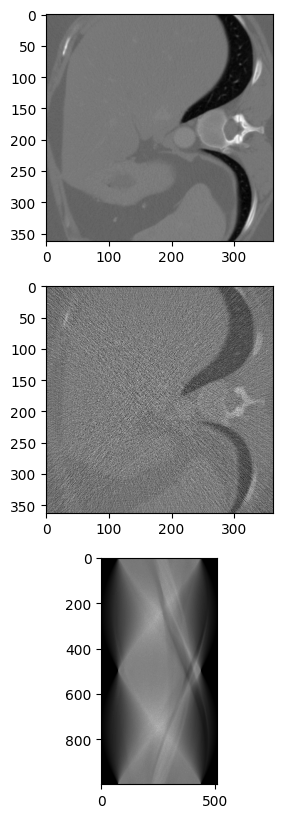

In [21]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

from tensorflow_graphics.geometry.transformation.rotation_matrix_2d import rotate
import tensorflow_addons as tfa


tf.config.experimental_run_functions_eagerly(False)

tf.debugging.set_log_device_placement(True)

class BackprojectionLayer(layers.Layer):
    def __init__(self, num_angles=180, **kwargs):
        super(BackprojectionLayer, self).__init__(**kwargs)
        self.num_angles = num_angles

    def ramp_filter(self, sinogram):
        """Apply 1D ramp filter to sinogram (correct frequency alignment)."""
        sinogram = tf.convert_to_tensor(sinogram)
        sin_sq = tf.squeeze(sinogram, axis=-1)  # [batch, angles, detectors]
        
        # 1D FFT with proper frequency ordering
        n = tf.shape(sin_sq)[-1]
        fft_sin = tf.signal.fft(tf.cast(sin_sq, tf.complex64))
        
        # Create ramp filter matching FFT frequency bins
        freq = tf.abs(tf.signal.fftshift(tf.linspace(-n//2, n//2, n)))
        ramp = tf.cast(freq / tf.reduce_max(freq), tf.complex64)  # Normalized [0,1]
        
        # Apply filter + inverse FFT
        filtered = tf.signal.ifft(fft_sin * ramp)
        return tf.expand_dims(tf.math.real(filtered), -1)  # [batch, angles, detectors, 1]

    def rotate_projection(self, projection, angle):
        """ Rotate a 1D projection back to 2D space at a given angle using pure TensorFlow. """
        angle_rad = angle * np.pi / 180.0
        cos_angle = tf.cos(angle_rad)
        sin_angle = tf.sin(angle_rad)

        # Create rotation matrix
        rotation_matrix = tf.stack([[cos_angle, -sin_angle], 
                                     [sin_angle, cos_angle]])

        # Tile the projection to create a 2D slice
        tiled_tensor = tf.tile(projection, [1, 513])
        rotated_coords = tfa.image.rotate(tiled_tensor, angle_rad, interpolation='nearest')

        return rotated_coords

    def backproject(self, sinogram, num_angles):
        """ Reconstruct the image from the filtered sinogram using backprojection """
        # Apply ramp filter to sinogram
        filtered_sinogram = self.ramp_filter(sinogram)

        # Angles for backprojection
        angles = tf.linspace(0.0, 180.0, num_angles)
        
        # Use tf.vectorized_map to apply rotation for all projections in parallel
        @tf.function
        def rotate_and_add(angle, projection):
            """ Rotate and add backprojections """
            rotated_projection = self.rotate_projection(projection, angle)
            return rotated_projection
        
        # Apply rotation and sum the backprojections
        rotated_images = tf.vectorized_map(
            lambda angle_proj: rotate_and_add(angle_proj[0], angle_proj[1]),
            (angles, filtered_sinogram[0])
        )
        
        # Sum up the rotated images (backprojections) to reconstruct the final image
        reconstructed_image = tf.reduce_sum(rotated_images, axis=0) / num_angles

        # Crop the reconstructed image
        offset_height = (513 - 362) // 2  # Top offset
        offset_width = (513 - 362) // 2   # Left offset
        added_dim = tf.expand_dims(reconstructed_image, axis=-1)
        cropped_image = tf.image.crop_to_bounding_box(
            added_dim,
            offset_height=offset_height,
            offset_width=offset_width,
            target_height=362,
            target_width=362
        )

        return cropped_image

    def call(self, sinogram):
        """ The forward pass of the inverse Radon transform. """
        # tf.print("SINOGRAM SHAPE:")
        # tf.print(tf.shape(sinogram))
        ret = self.backproject(sinogram, self.num_angles)
        # tf.print("SHAPE AT THE END OF THE BACKPROJ")
        # tf.print(ret.shape)
        return ret
    

num_angles = 1000
input_shape = (None, 1000, 513, 1)  # Example input shape: batch, num_detectors, num_angles, 1 channel

inputs = layers.Input(shape=input_shape[1:])  # Remove batch size for input shape
bp_layer = BackprojectionLayer(num_angles=num_angles)(inputs)

# Build and test the model
model = tf.keras.models.Model(inputs, bp_layer)
model.summary()

# Test the layer with eager execution
def test_backprojection(model):

    im = 0
    gttest_path = Path(base_path_win,'gt_test/ground_truth_test_000.hdf5')
    obtest_path = Path(base_path_win,'observations_test/observation_test_000.hdf5')
    file_gttest = h5py.File(gttest_path)
    file_obtest = h5py.File(obtest_path)
    data_gttest = file_gttest['data']
    data_obtest = file_obtest['data']
    img_obtest = data_obtest[im]

    img_gttest = data_gttest[im][:][:]
    # print(img_gttest.shape)
    img_array = np.expand_dims(img_obtest, axis=-1)  # Shape becomes (1000, 513, 1)

    # Step 3: Normalize the image if needed (optional, depending on your model's training)
    #img_array = img_array / 255.0  # Normalize the image data (if your model expects it)

    # Step 4: Add batch dimension (1 image in a batch)
    img_array = np.expand_dims(img_array, axis=0)
    print(img_array.shape)
    img_result = model.predict(img_array)
    print("INPUT DATATYPE: ", img_array.dtype)
    print("OUTPUT DTYPE: ", img_result.dtype)
    # Simulate input data
    input_data = np.random.rand(1, 1000, 513, 1).astype(np.float32)  # Single example sinogram

    fig, axs = plt.subplots(3, 1, figsize = (3, 10))
    axs[0].imshow(img_gttest, cmap = 'grey')
    axs[1].imshow(img_result, cmap = 'grey')
    axs[2].imshow(img_obtest, cmap = 'grey')
    plt.savefig('my_plot_nopool.png', format='png')
    
    # print("Output shape:", img_result.shape)
    return img_result

my_bp_image = test_backprojection(model)

In [22]:
# array1 = tf.linspace(1, 10, 10)
# complex = 
# array2 = tf.linspace(1, 10, 10)
# arrayek = array1 * array2

# tensor = tf.tile(tf.expand_dims(array1, axis=0), [5,1])
# tf.print(tensor)
# Tdtensor = tf.expand_dims(tensor, axis = -1)
# # tf.print(Tdtensor)
# Fdtensor = tf.expand_dims(Tdtensor, axis = 0)
# tf.print(tf.shape(Fdtensor))
# # tf.print(Fdtensor)
# sima = tf.squeeze(Fdtensor)
# multi = tf.map_fn(lambda row: row*array1, sima)
# tf.print(multi)
# tf.print(tf.linspace(0, 1, 1))

## Part 5: Create visualization and evaluation function

In [33]:
from skimage.transform import radon, iradon
import skimage
def inference_and_visualize(model: tf.keras.models.Model, im: int=20, file_number: str='000',
                            show_metrics=True,  base_path_win = Path('/mnt/d/Masters/Medical_Imaging'), figsize: tuple=(14, 30)):
    """
    Infers the model , visualizes the gt image, inferred image, noisy sinogram, fbp reconstructed image
    Args: 
        model: tensorflow_model - model to make the inference with
        im: int - number of imag in the file, the max is 128 for this dataset
        file_number: str -number of fil on disk, for this dataset it's 0-256
    """
    gttest_path = Path(base_path_win,f'gt_test/ground_truth_test_{file_number}.hdf5')
    obtest_path = Path(base_path_win,f'observations_test/observation_test_{file_number}.hdf5')
    file_gttest = h5py.File(gttest_path)
    file_obtest = h5py.File(obtest_path)
    data_gttest = file_gttest['data']
    data_obtest = file_obtest['data']
    img_obtest = data_obtest[im]

    img_gttest = data_gttest[im][:][:]
    print(img_gttest.shape)
    img_array = np.expand_dims(img_obtest, axis=-1)  # Shape becomes (1000, 513, 1)

    # Step 3: Normalize the image if needed (optional, depending on your model's training)
    #img_array = img_array / 255.0  # Normalize the image data (if your model expects it)

    # Step 4: Add batch dimension (1 image in a batch)
    img_array = np.expand_dims(img_array, axis=0)
    img_result = model.predict(img_array)
    print(img_result.shape)
    img = np.squeeze(img_result)
    print(img.shape)

    theta = np.linspace(0, 180, 1000, endpoint=False)
    # sinogram = radon(img_obtest, theta=theta)
    rotated_sin = skimage.transform.rotate(img_obtest, 90, resize=True)

    # Perform filtered back projection with a Hann filter
    reconstruction_fbp = iradon(rotated_sin, theta=theta, filter_name='ramp', output_size=img_gttest.shape[0], circle=False)
    reconstruction_fbp = skimage.transform.rotate(reconstruction_fbp, 90, resize=False)
    fig, axs = plt.subplots(4, 1, figsize = figsize)
    axs[0].imshow(img_gttest, cmap = 'grey')
    axs[1].imshow(img, cmap = 'grey')
    axs[2].imshow(rotated_sin, cmap = 'grey')
    axs[3].imshow(reconstruction_fbp, cmap = 'grey')


    test_gt_exp = tf.expand_dims(img_gttest, -1)
    test_gt_exp = tf.expand_dims(test_gt_exp, 0)

    test_result = tf.expand_dims(img, 0)
    test_result = tf.expand_dims(test_result, -1)

    test_fbp = tf.expand_dims(reconstruction_fbp, 0)
    test_fbp = tf.expand_dims(test_fbp, -1)
    if show_metrics:
        print(test_gt_exp.shape)
        print(test_result.shape)
        print(test_fbp.shape)
        # test_gt_exp = tf.expand_dims(test_gt_exp, 1)
        print("PERCEPTUAL LOSS: ")
        print("inferred: ", perceptual_loss(test_gt_exp, test_result))
        print("fbp reconstruction: ",perceptual_loss(test_gt_exp, test_fbp))
        print(" ")
        print("GRANDIENT LOSS: ")
        print("inferred: ",gradient_loss(test_gt_exp, test_result))
        print("fbp reconstruction: ",gradient_loss(test_gt_exp, test_fbp))
        print(" ")
        print("MSE LOSS: ")
        print("inferred: ",tf.reduce_mean(tf.square(test_gt_exp - test_result)))
        print("fbp reconstruction: ",tf.reduce_mean(tf.square(test_gt_exp - test_fbp)))
        print(" ")
        print("MAE LOSS: ")
        print("inferred: ",tf.reduce_mean(test_gt_exp - test_result))
        print("fbp reconstruction: ",tf.reduce_mean(test_gt_exp - test_fbp))
        print(" ")
        print("PSNR LOSS: ")
        print("inferred: ",tf.image.psnr(test_gt_exp, test_result, 1))
        print("fbp reconstruction: ",tf.image.psnr(test_gt_exp, test_fbp, 1))
        print(" ")
        print("FOURIER LOSS: ")
        print("inferred: ", frequency_loss(test_gt_exp, test_result))
        print("fbp reconstruction: ", frequency_loss(test_gt_exp, test_fbp))
        print(" ")


    return test_gt_exp # return the tensor
        

## Part 6: Build Old Model

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 1000, 513, 1)]       0         []                            
                                                                                                  
 backprojection_layer_6 (Ba  (362, 362, 1)                0         ['input_8[0][0]']             
 ckprojectionLayer)                                                                               
                                                                                                  
 tf.stop_gradient_5 (TFOpLa  (362, 362, 1)                0         ['backprojection_layer_6[0][0]
 mbda)                                                              ']                            
                                                                                            

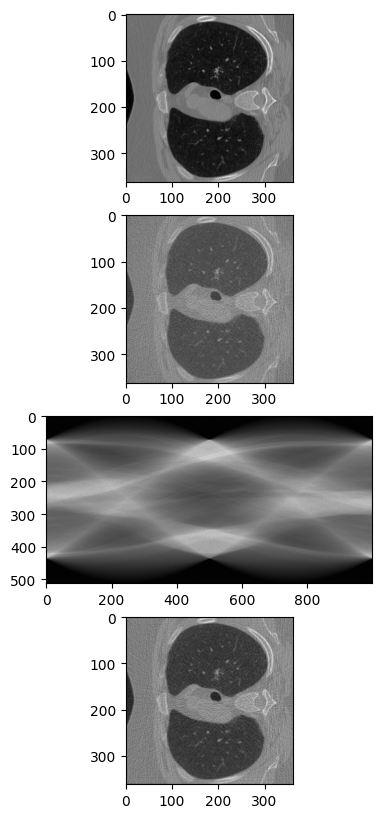

In [34]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam


input_shape = (None, 1000, 513, 1)  # Example input shape: batch, num_detectors, num_angles, 1 channel
output_shape = (362, 362, 1)
num_angles = 1000


inputs = layers.Input(shape=input_shape[1:])  # Remove batch size for input shape

# DUE TO THE STOPPING INT THE BACKPROJECTON LAYER IT MAKES NO SENSE SO FILTER WITH THIS MODEL THE SINOGRAM. IT SHOULD BE DONE IN 2 PARTS
# c1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same',
#                        kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(inputs)

# c2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same',
#                        kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(c1)

# c25 = layers.Conv2D(32, (3, 3), activation='relu', padding='same',
#                        kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(c2)
# c3 = layers.Conv2D(16, (3, 3), activation='relu', padding='same',
#                        kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(c25)

# c2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same',
#                        kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(c1) #3reteg, 16, 32, 64 0.01rol is ment

# c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same',
#                        kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(inputs) #128 3, 3 volt ami ment 0.01 rol kezdodo LR-el

# sig = layers.Conv2D(output_shape[-1], (1, 1), activation='sigmoid', padding='same')(c3)

bp_layer = BackprojectionLayer(num_angles=num_angles)(inputs)
sg = tf.stop_gradient(bp_layer)
expand_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=0))(sg)
normalize_layer = layers.Lambda(normalize_image)(expand_layer)

x1 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(normalize_layer)
x1a = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x1)
x1b = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x1a)
x1_down = layers.Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(x1b)  # (181, 181, 128)

# Block 2: 181x181 -> 91x91 (stride=2)
x2 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(x1_down)
x2a = layers.Conv2D(256, (3,3), activation='relu', padding='same')(x2)
x2b = layers.Conv2D(256, (3,3), activation='relu', padding='same')(x2a)
x2_down = layers.Conv2D(512, (3,3), activation='relu', padding='same', strides=2)(x2)  # (91, 91, 256)

x2_bn1 = layers.Conv2D(512, (3,3), activation='relu', padding='same')(x2_down)

x2_bn2 = layers.Conv2D(512, (3,3), activation='relu', padding='same')(x2_bn1)
# --------------
# Decoder
# --------------
# Block 3: 91x91 -> 182x182 (transposed conv)
x3_up = layers.Conv2DTranspose(256, (3,3), activation='relu', padding='same', strides=2)(x2_bn2)  # (182, 182, 128)
x3a = layers.Conv2D(256, (3,3), activation='relu', padding='same')(x3_up)
x3b = layers.Conv2D(256, (3,3), activation='relu', padding='same')(x3a)
# Pad x1_down (181x181 -> 182x182) to match x3_up
x1_down_padded = layers.ZeroPadding2D(((0,1), (0,1)))(x1_down)  # (182, 182, 128)
x3_merge = layers.concatenate([x3b, x1_down_padded])  # (182, 182, 256)

# Block 4: 182x182 -> 364x364 (transposed conv)
x4_up = layers.Conv2DTranspose(128, (3,3), activation='relu', padding='same', strides=2)(x3_merge)  # (364, 364, 64)
x4a = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x4_up)
x4b = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x4a)
# Pad input (362x362 -> 364x364) to match x4_up
# inputs_padded = layers.ZeroPadding2D(((1,1), (1,1)))(x1)  # (364, 364, 1)
x1_padded = layers.ZeroPadding2D(((1,1), (1,1)))(x1)
x4_merge = layers.concatenate([x4b, x1_padded])  # (364, 364, 65)

# Residual prediction and output
residual = layers.Conv2D(1, (3,3), activation='linear', padding='same')(x4_merge)  # (364, 364, 1)
crop = layers.Cropping2D(((1,1), (1,1)))(residual)  # (362, 362, 1)

final_add = layers.Add()([normalize_layer, crop])  # (364, 364, 1)

# Crop back to original size (364x364 -> 362x362)


# Build and test the model
model = tf.keras.models.Model(inputs, final_add)


# Create the model
# input_shape = (1000, 513, 1)  # Single sinogram as input
# output_shape = (362, 362, 1)  # Reconstructed image
# model = unet_model(input_shape, output_shape)

# Set up Adam optimizer with gradient clipping
# optimizer = Adam(clipvalue=1.0)  # Clip gradients by value (to prevent explosion)
# Adam = Adam(clipnorm=1.0)

lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[150, 250, 500, 1000, 2000],      # Steps where the learning rate will change
    values=[0.001, 0.005, 0.0001, 0.0005, 0.00001, 0.00005]  # Corresponding learning rates at those boundaries
)

Adam = tf.keras.optimizers.Adam(learning_rate=0.01)
Nadam = tf.keras.optimizers.Nadam(learning_rate=0.01)


AdamW = tf.keras.optimizers.AdamW(
    learning_rate=0.0001,
    weight_decay=1e-4,  # Critical hyperparameter
    beta_1=0.9,
    beta_2=0.995,
    epsilon=1e-07
)

# Compile the model
# model.compile(optimizer='Adam', loss=custom_loss, metrics=['mse'])
model.compile(optimizer=Adam, loss=custom_loss)

# Summary of the model
print(model.summary())
gt_tensor =inference_and_visualize(model, 20, show_metrics=False, figsize=(6, 10))

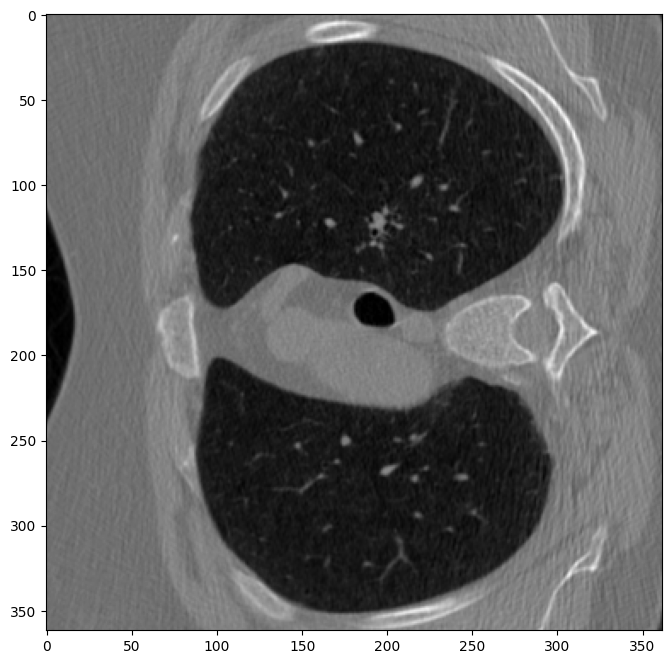

In [54]:
plt.figure(figsize=(8, 8))
myim = tf.squeeze(gt_tensor)
plt.imshow(myim, cmap='gray')

## Part 7: Creating patches for new model

In [68]:
patchez = tf.image.extract_patches(images=gt_tensor,
                           sizes=[1, 16, 16, 1],
                           strides=[1, 16, 16, 1],
                           rates=[1, 1, 1, 1],
                           padding='SAME') # padding will convert to 368 * 368, so 3 pixel is added around

In [69]:
patchez.shape

TensorShape([1, 23, 23, 256])

### Visualizing created patches

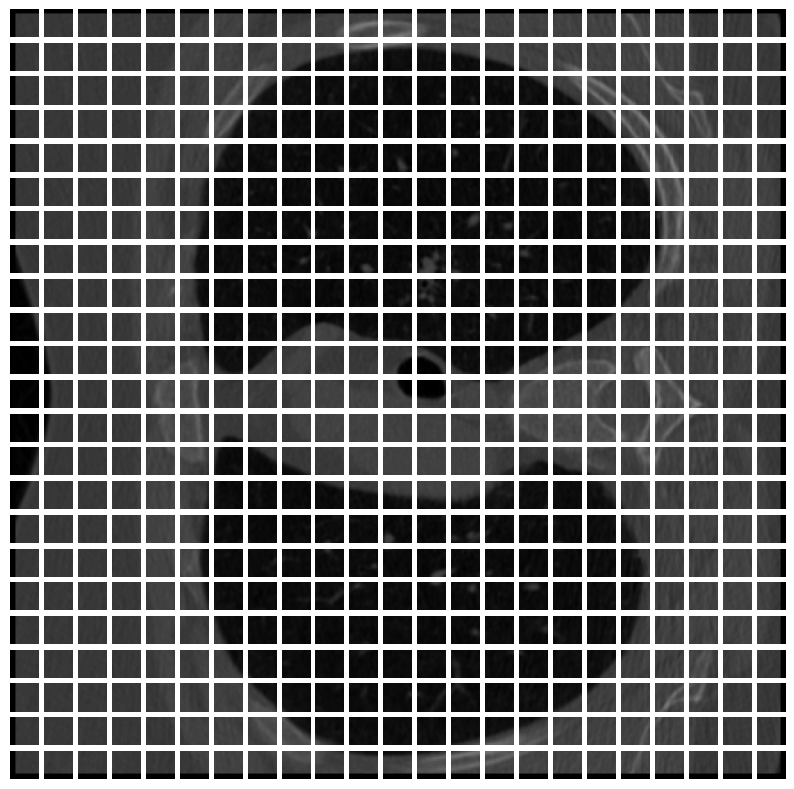

In [70]:
plt.figure(figsize = (10, 10))
k = 0
for i in range(23):
    for j in range(23):
        ax = plt.subplot(23, 23, k+1)
        plt.imshow(tf.reshape(patchez[0, i, j, :], (16, 16, 1)), cmap = 'gray', vmin = 0, vmax = 1)
        plt.axis("off")
        k = k+1


In [127]:
patchez.shape

TensorShape([1, 23, 23, 256])

In [141]:
# class PatchesToImage(layers.Layer):
#     def __init__(self, imgh, imgw, imgc, patsz, is_squeeze=True, **kwargs):
#         super(PatchesToImage, self).__init__(**kwargs)
#         self.H = (imgh // patsz) * patsz
#         self.W = (imgw // patsz) * patsz
#         self.C = imgc
#         self.P = patsz
#         self.is_squeeze = is_squeeze
        
#     def call(self, inputs):
#         bs = tf.shape(inputs)[0]
#         rows, cols = self.H // self.P, self.W // self.P
#         patches = tf.reshape(inputs, [bs, rows, cols, -1, self.C])
#         pats_by_clist = tf.unstack(patches, axis=-1)
#         def tile_patches(ii):
#             pats = pats_by_clist[ii]
#             img = tf.nn.depth_to_space(pats, self.P)
#             return img 
#         img = tf.map_fn(fn=tile_patches, elems=tf.range(self.C), fn_output_signature=inputs.dtype)
#         img = tf.squeeze(img, axis=-1)
#         img = tf.transpose(img, perm=[1,2,3,0])
#         C = tf.shape(img)[-1]
#         img = tf.cond(tf.logical_and(tf.constant(self.is_squeeze), C==1), 
#                       lambda: tf.squeeze(img, axis=-1), lambda: img)
#         return img

class PatchesToImage(layers.Layer):
    def __init__(self, imgh, imgw, imgc, patsz, is_squeeze=True, **kwargs):
        super(PatchesToImage, self).__init__(**kwargs)
        self.H = (imgh // patsz) * patsz
        self.W = (imgw // patsz) * patsz
        self.C = imgc
        self.P = patsz
        self.is_squeeze = is_squeeze
        
    def call(self, inputs):
        bs = tf.shape(inputs)[0]
        rows, cols = self.H // self.P, self.W // self.P
        
        # Reshape to [batch, rows, cols, P^2, C]
        patches = tf.reshape(inputs, [bs, rows, cols, self.P**2, self.C])
        
        # Define a function to process each channel using tensor indexing
        def tile_patches(ii):
            # Select the i-th channel's patches [batch, rows, cols, P^2]
            pats = patches[..., ii]
            # Reconstruct spatial structure for this channel
            img = tf.nn.depth_to_space(pats, self.P)  # Output shape: [batch, H, W, 1]
            return img
        
        # Process all channels in parallel (no Python list indexing)
        img = tf.map_fn(
            fn=tile_patches, 
            elems=tf.range(self.C), 
            fn_output_signature=inputs.dtype
        )
        
        # Combine channels and adjust dimensions
        img = tf.squeeze(img, axis=-1)   # Shape: [C, batch, H, W]
        img = tf.transpose(img, perm=[1, 2, 3, 0])  # Shape: [batch, H, W, C]
        
        # Squeeze channel dimension if needed
        if self.is_squeeze and self.C == 1:
            img = tf.squeeze(img, axis=-1)
        
        return img

### Attempting to restore images from patches

In [142]:
reconvert = PatchesToImage(imgh=368, imgw=368, imgc=1, patsz = 16, is_squeeze=False)
myim = reconvert(patchez)

(368, 368, 1)


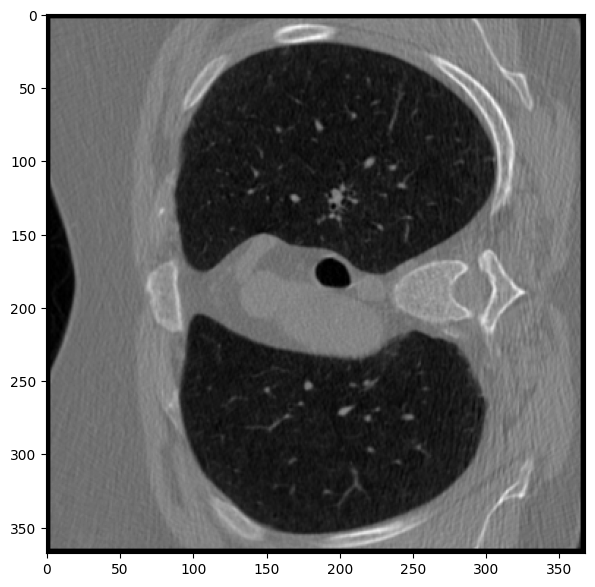

In [143]:
plt.figure(figsize=(7, 7))
recim = tf.squeeze(myim, axis=0)
plt.imshow(recim, cmap='gray')
print(recim.shape)

### Cropping image back to its original shape

In [117]:
print(myim.shape)
myim = tf.expand_dims(myim, axis=-1)
print(myim.shape)

(1, 368, 368)
(1, 368, 368, 1)


(362, 362, 1)


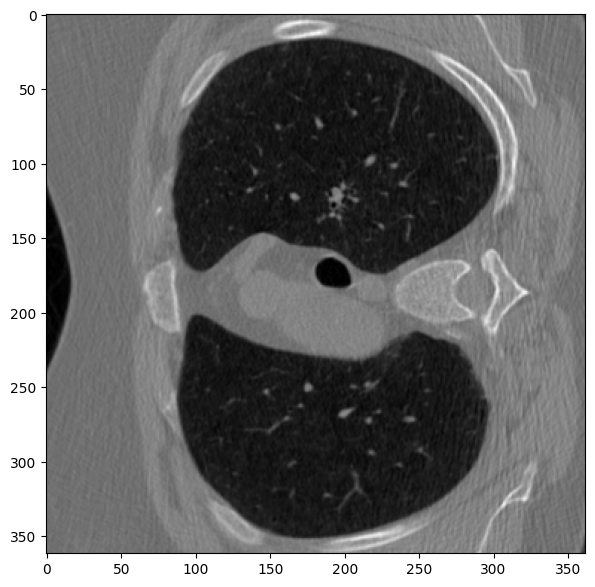

In [118]:
crop = layers.Cropping2D(((3,3), (3,3)))(myim)
plt.figure(figsize=(7, 7))
cropsq = tf.squeeze(crop, axis=0)
plt.imshow(cropsq, cmap='gray')
print(cropsq.shape)

### Reshaping patchez so that we can feed it into th vision transformer

In [73]:
resh_patch = tf.reshape(patchez, (patchez.shape[0], 529, 256))
resh_patch.shape

TensorShape([1, 529, 256])

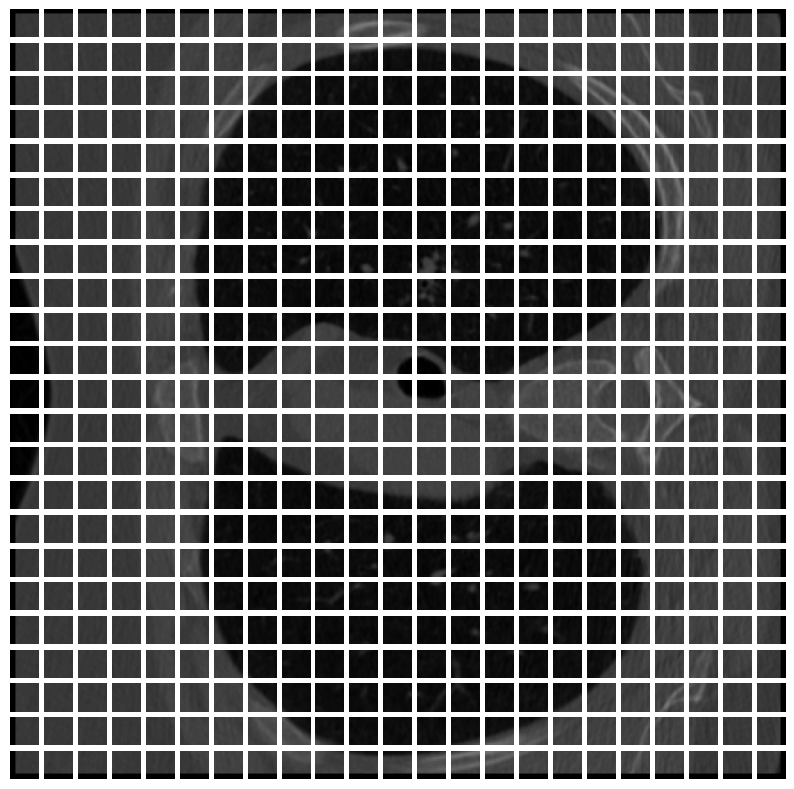

In [76]:
plt.figure(figsize = (10, 10))
for i in range(529):
    ax = plt.subplot(23, 23, i+1)
    plt.imshow(tf.reshape(resh_patch[0, i, :], (16, 16, 1)), cmap = 'gray', vmin = 0, vmax = 1)
    plt.axis("off")

### Attempting to restore images from reshaped patches

In [109]:
pagain = tf.reshape(resh_patch, (1, 23, 23, 256))
pagain.shape

TensorShape([1, 23, 23, 256])

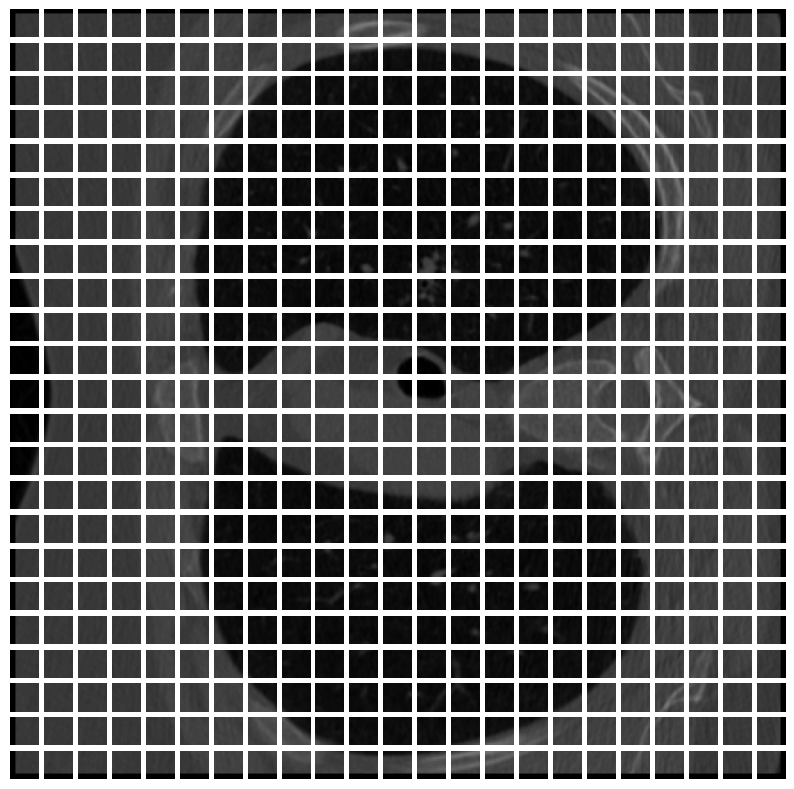

In [110]:
plt.figure(figsize = (10, 10))
k = 0
for i in range(23):
    for j in range(23):
        ax = plt.subplot(23, 23, k+1)
        plt.imshow(tf.reshape(pagain[0, i, j, :], (16, 16, 1)), cmap = 'gray', vmin = 0, vmax = 1)
        plt.axis("off")
        k = k+1

###  Creating Patch Encoder Layer

In [82]:
class PatchEncoder(layers.Layer):
    # num patches has to be 23*23 = 529
    # hidden size should be 256 as the number of colors (OR the 16*16 pixels per color channel? )
    def __init__(self, num_patches, num_hidden):
        self.num_patches = num_patches
        self.linear_projection = layers.Dense(num_hidden)
        self.positional_embedding = layers.Embedding(num_patches, num_hidden)
        super(PatchEncoder, self).__init__(name="patch_encoder")

    def patch_encode(self, img_tensor):
        patchez = tf.image.extract_patches(images=img_tensor,
                           sizes=[1, 16, 16, 1],
                           strides=[1, 16, 16, 1],
                           rates=[1, 1, 1, 1],
                           padding='SAME') # padding will convert to 368 * 368, so 3 pixel is added around which has to be removed later
        resh_patch = tf.reshape(patchez, (patchez.shape[0], 529, 256))
        return resh_patch
    
    def call(self, img_tensor):
        patched_img = self.patch_encode(img_tensor)
        emb_input = tf.range(start=0, limit=self.num_patches, delta=1)
        output = self.linear_projection(patched_img) + self.positional_embedding(emb_input)
        return output
    
    

In [83]:
patch_enc = PatchEncoder(529, 256)
result = patch_enc(tf.zeros(shape=(1, 362, 362, 1)))
result.shape

TensorShape([1, 529, 256])

## Part 8: Creating Transformer Encoder Layer

In [147]:
class TransformerEncoder(layers.Layer):
    # vision transformer article: https://arxiv.org/pdf/2010.11929
    def __init__(self, num_heads, hidden_size):
        self.norm_1 = layers.Normalization()
        self.norm_2 = layers.Normalization()

        self.multi_head_attention = layers.MultiHeadAttention(num_heads, hidden_size)

        self.dense_1 = layers.Dense(hidden_size, activation=tf.nn.gelu)
        self.dense_2 = layers.Dense(hidden_size, activation=tf.nn.gelu)
        super(TransformerEncoder, self).__init__()

    def call(self, patch_tensor):
        l1 = self.norm_1(patch_tensor)
        l2 = self.multi_head_attention(l1, l1)
        l3 = layers.Add()([l2, patch_tensor])
        l4 = self.norm_2(l3)
        l5 = self.dense_1(l4)
        l6 = self.dense_2(l5)
        output = layers.Add()([l6, l3])

        return output

In [135]:
t1 = TransformerEncoder(4, 256)
tres = t1(result)
tres.shape

TensorShape([1, 529, 256])

In [136]:
t2 = TransformerEncoder(4, 256)
tres2 = t2(tres)
tres2.shape

TensorShape([1, 529, 256])

In [137]:
resh = layers.Reshape((23, 23, 256))
rshres = resh(tres2)
rshres.shape

TensorShape([1, 23, 23, 256])

In [138]:
rec = reconvert(rshres)

In [139]:
rec.shape

TensorShape([1, 368, 368, 1])

## Part9: Building transformer model:

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_36 (InputLayer)       [(None, 1000, 513, 1)]       0         []                            
                                                                                                  
 backprojection_layer_34 (B  (362, 362, 1)                0         ['input_36[0][0]']            
 ackprojectionLayer)                                                                              
                                                                                                  
 tf.stop_gradient_33 (TFOpL  (362, 362, 1)                0         ['backprojection_layer_34[0][0
 ambda)                                                             ]']                           
                                                                                           

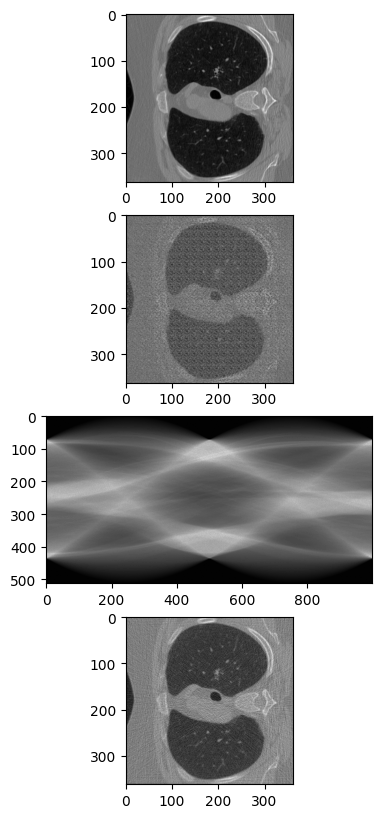

In [164]:
input_shape = (None, 1000, 513, 1)  # Example input shape: batch, num_detectors, num_angles, 1 channel
output_shape = (362, 362, 1)
num_angles = 1000


inputs = layers.Input(shape=input_shape[1:])  # Remove batch size for input shape

bp_layer = BackprojectionLayer(num_angles=num_angles)(inputs)
sg = tf.stop_gradient(bp_layer)
expand_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=0))(sg)
normalize_layer = layers.Lambda(normalize_image)(expand_layer)

patch_enc = PatchEncoder(529, 256)(normalize_layer)

t1 = TransformerEncoder(4, 256)(patch_enc)

t2 = TransformerEncoder(4, 256)(t1)

t3 = TransformerEncoder(4, 256)(t2)

t4 = TransformerEncoder(4, 256)(t3)

t5 = TransformerEncoder(4, 256)(t4)

resh = layers.Reshape([23, 23, 256])(t5)

rec = PatchesToImage(imgh=368, imgw=368, imgc=1, patsz = 16, is_squeeze=False)(resh)

norm = layers.Normalization()(rec)

crop = layers.Cropping2D(((3,3), (3,3)))(norm)

output = layers.Conv2D(1, (3,3), activation='linear', padding='same')(crop)

norm = layers.Normalization()(output)

final_add = layers.Add()([normalize_layer, norm])




# Build and test the model
model = tf.keras.models.Model(inputs, final_add)


# Create the model
# input_shape = (1000, 513, 1)  # Single sinogram as input
# output_shape = (362, 362, 1)  # Reconstructed image
# model = unet_model(input_shape, output_shape)

# Set up Adam optimizer with gradient clipping
# optimizer = Adam(clipvalue=1.0)  # Clip gradients by value (to prevent explosion)
# Adam = Adam(clipnorm=1.0)

lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[150, 250, 500, 1000, 2000],      # Steps where the learning rate will change
    values=[0.001, 0.005, 0.0001, 0.0005, 0.00001, 0.00005]  # Corresponding learning rates at those boundaries
)

Adam = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm = 1.0)
Nadam = tf.keras.optimizers.Nadam(learning_rate=0.01)


AdamW = tf.keras.optimizers.AdamW(
    learning_rate=0.0001,
    weight_decay=1e-4,  # Critical hyperparameter
    beta_1=0.9,
    beta_2=0.995,
    epsilon=1e-07
)

# Compile the model
# model.compile(optimizer='Adam', loss=custom_loss, metrics=['mse'])
model.compile(optimizer=Adam, loss=custom_loss)
print(model.summary())
gt_tensor =inference_and_visualize(model, 20, show_metrics=False, figsize=(6, 10))

In [94]:
transf = TransformerEncoder(8, 256)
result = transf(tf.zeros(shape=(1, 529, 256)))
result.shape

TensorShape([1, 529, 256])

## Part End: Fit Model

In [ ]:

from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

observation_files = [os.path.join(OBSERVATION_DIR, f) for f in os.listdir(OBSERVATION_DIR) if f.endswith('.hdf5')]
ground_truth_files = [os.path.join(GROUND_TRUTH_DIR, f) for f in os.listdir(GROUND_TRUTH_DIR) if f.endswith('.hdf5')]
obs_val_files = [os.path.join(VAL_OBS_DIR, f) for f in os.listdir(VAL_OBS_DIR) if f.endswith('.hdf5')]
gt_val_files = [os.path.join(VAL_GT_DIR, f) for f in os.listdir(VAL_GT_DIR) if f.endswith('.hdf5')]
print(observation_files)
# For testing, you can limit the number of files loaded
observation_files = observation_files[:1]  # Load just 8 files for testing
ground_truth_files = ground_truth_files[:1]  # Load just 8 files for testing

obs_val_files = obs_val_files[:1]
gt_val_files = gt_val_files[:1]

train_dataset = create_dataset(observation_files, ground_truth_files, BATCH_SIZE)
val_dataset = create_dataset(obs_val_files, gt_val_files, 1)
# verify the training dataset
for obs, gt in train_dataset.take(1):  # Take one batch
        print("Observation batch shape:", obs.shape)
        print("Ground truth batch shape:", gt.shape)
# calculate steps per peoch
steps_per_epoch=len(observation_files*128) // BATCH_SIZE
print(steps_per_epoch)

checkpoint_cb = ModelCheckpoint(
    'model_checkpoint.h5',  # Path where the checkpoint will be saved
    save_best_only=True,    # Save only the best model (based on monitored metric)
    monitor='val_loss',         # Monitor the training loss
    mode='min',             # Save when the loss decreases (best model)
    verbose=1               # Print messages when the model is saved
)

#dropout-ot megnezni megegyszer
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=2, min_lr=1e-6)
# , callbacks=[lr_scheduler]
model.fit(train_dataset, epochs=2, steps_per_epoch=steps_per_epoch)

['/mnt/d/Masters/Medical_Imaging/observations_train/observation_train_000.hdf5', '/mnt/d/Masters/Medical_Imaging/observations_train/observation_train_001.hdf5', '/mnt/d/Masters/Medical_Imaging/observations_train/observation_train_002.hdf5', '/mnt/d/Masters/Medical_Imaging/observations_train/observation_train_003.hdf5', '/mnt/d/Masters/Medical_Imaging/observations_train/observation_train_004.hdf5', '/mnt/d/Masters/Medical_Imaging/observations_train/observation_train_005.hdf5', '/mnt/d/Masters/Medical_Imaging/observations_train/observation_train_006.hdf5', '/mnt/d/Masters/Medical_Imaging/observations_train/observation_train_007.hdf5', '/mnt/d/Masters/Medical_Imaging/observations_train/observation_train_008.hdf5', '/mnt/d/Masters/Medical_Imaging/observations_train/observation_train_009.hdf5', '/mnt/d/Masters/Medical_Imaging/observations_train/observation_train_010.hdf5', '/mnt/d/Masters/Medical_Imaging/observations_train/observation_train_011.hdf5', '/mnt/d/Masters/Medical_Imaging/observa

(362, 362)
1/1 [==============================] - 2s 2s/step
(1, 362, 362, 1)
(362, 362)
(1, 362, 362, 1)
(1, 362, 362, 1)
(1, 362, 362, 1)
PERCEPTUAL LOSS: 
inferred:  tf.Tensor(nan, shape=(), dtype=float32)
fbp reconstruction:  tf.Tensor(20.444242, shape=(), dtype=float32)
 
GRANDIENT LOSS: 
inferred:  tf.Tensor(nan, shape=(), dtype=float32)
fbp reconstruction:  tf.Tensor(0.11203769, shape=(), dtype=float32)
 
MSE LOSS: 
inferred:  tf.Tensor(nan, shape=(), dtype=float32)
fbp reconstruction:  tf.Tensor(0.025429944, shape=(), dtype=float32)
 
MAE LOSS: 
inferred:  tf.Tensor(nan, shape=(), dtype=float32)
fbp reconstruction:  tf.Tensor(0.11254174, shape=(), dtype=float32)
 
PSNR LOSS: 
inferred:  tf.Tensor([nan], shape=(1,), dtype=float32)
fbp reconstruction:  tf.Tensor([15.946546], shape=(1,), dtype=float32)
 
FOURIER LOSS: 
inferred:  tf.Tensor(nan, shape=(), dtype=float32)
fbp reconstruction:  tf.Tensor(0.7712662, shape=(), dtype=float32)
 


<tf.Tensor: shape=(1, 362, 362, 1), dtype=float32, numpy=
array([[[[0.0000000e+00],
         [0.0000000e+00],
         [0.0000000e+00],
         ...,
         [5.7041574e-02],
         [5.2967113e-02],
         [4.2451765e-02]],

        [[0.0000000e+00],
         [0.0000000e+00],
         [0.0000000e+00],
         ...,
         [6.5497667e-02],
         [6.0972042e-02],
         [4.9997717e-02]],

        [[0.0000000e+00],
         [0.0000000e+00],
         [0.0000000e+00],
         ...,
         [9.9460386e-02],
         [6.1792329e-02],
         [3.7123218e-02]],

        ...,

        [[1.2996970e-03],
         [4.9346709e-03],
         [1.2288735e-03],
         ...,
         [2.1167792e-01],
         [2.2069557e-01],
         [2.4147548e-01]],

        [[0.0000000e+00],
         [0.0000000e+00],
         [0.0000000e+00],
         ...,
         [2.2144389e-01],
         [2.3051541e-01],
         [2.5373167e-01]],

        [[0.0000000e+00],
         [0.0000000e+00],
         [1.7657

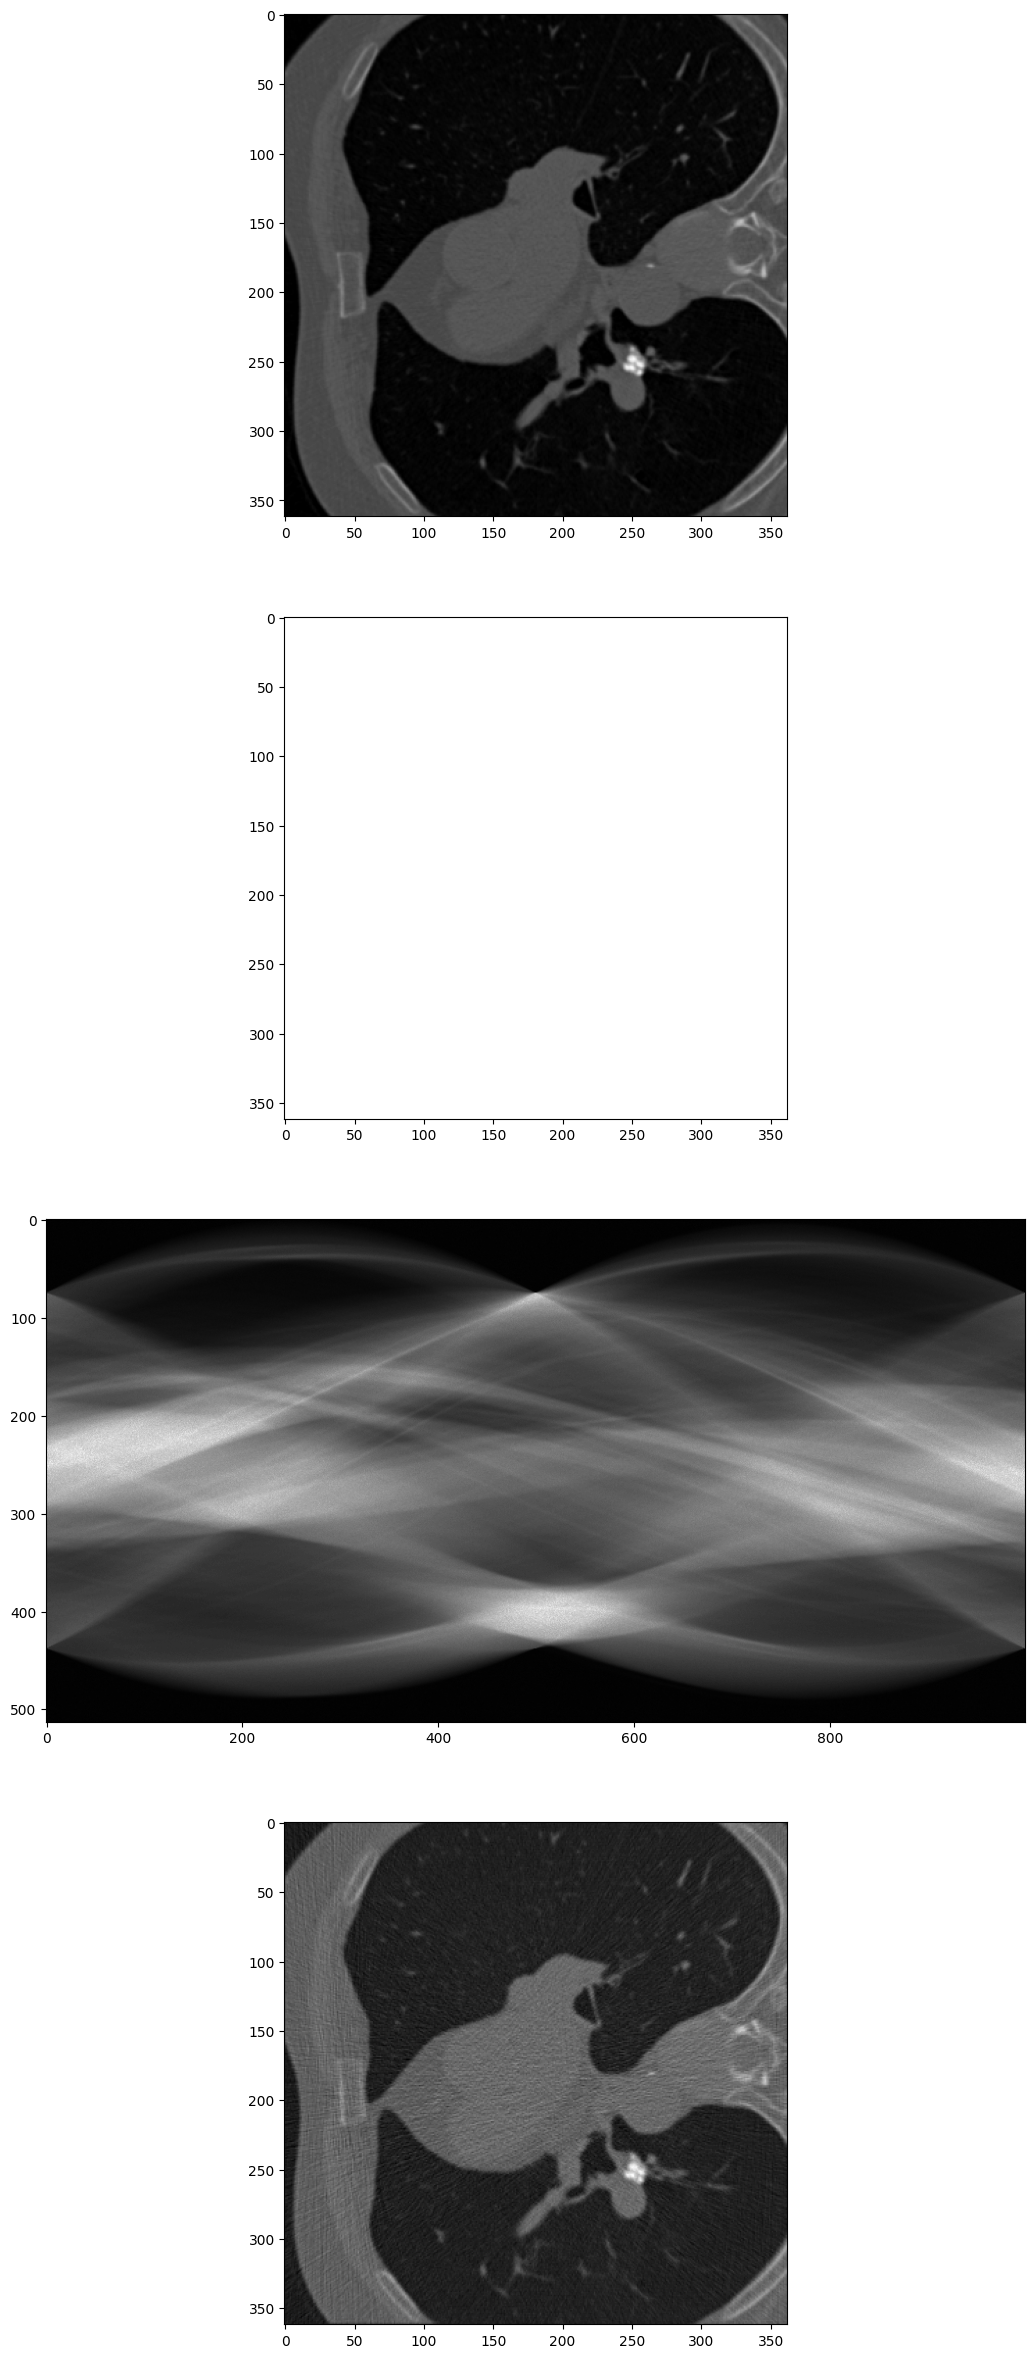

In [153]:
inference_and_visualize(model, 45)

In [ ]:

base_path = "saved_models_march_3/"
files = os.listdir(base_path)
new_index = len(files) + 1
base_model_name = "image_domain_filter_UNET_PERFECT_BETTER_THAN_GROUND_TRUTH"
model_name = base_model_name + str(new_index)
save_path = base_path + model_name + ".h5"
save_path

'saved_models_march_3/image_domain_filter_UNET_PERFECT_BETTER_THAN_GROUND_TRUTH9.h5'

flow_from_directory function can do image loading easily if the images are individual

In [ ]:
save_path

'saved_models_march_3/image_domain_filter_UNET_PERFECT_BETTER_THAN_GROUND_TRUTH9.h5'

In [ ]:
model.save(save_path)

In [ ]:
model.history

In [ ]:
if hasattr(model, 'history') and model.history:
    print("Training history is available.")
    print("History keys:", model.history.history.keys())  # To check the available metrics in history
else:
    print("No training history found.")

Training history is available.
History keys: dict_keys([])


In [ ]:
import tensorflow.keras.backend as K
def variance_penalty_loss(y_true, y_pred):
    """ 
    Parabolic penalty function for a single image that penalizes both underestimation 
    and overestimation of variance in the predicted image.
    """
    # Compute variance for the entire image
    var_true = 1000*K.var(y_true)  # Variance of true image
    var_pred = 1000*K.var(y_pred)  # Variance of predicted image
    
    # Parabolic penalty: (var_pred - var_true)^2
    loss = K.square(var_true -var_pred)  
    
    return loss

In [ ]:
print(model_name)

image_domain_filter_UNET_almost_perfect7


In [ ]:
def edge_aware_loss(y_pred):
    # Compute Sobel gradients
    sobel_x = tf.image.sobel_edges(y_pred)[..., 0]  # Horizontal edges
    sobel_y = tf.image.sobel_edges(y_pred)[..., 1]  # Vertical edges
    gradient_magnitude = tf.sqrt(sobel_x**2 + sobel_y**2 + 1e-6)
    
    # Penalize images with weak edges (negative sign to maximize gradients)
    return -tf.reduce_mean(gradient_magnitude)

def variance_regularization_loss(y_pred):
    # Penalize low variance (flat images)
    spatial_variance = tf.math.reduce_variance(y_pred, axis=[1, 2, 3])
    return -tf.reduce_mean(spatial_variance)  # Negative sign to encourage variance

(362, 362)
1/1 [==============================] - 0s 358ms/step


IMG RESULT SHAPE (1, 362, 362, 1)
(362, 362)
(1, 362, 362, 1)
OUTPUT IMAGE SHAPE (1, 362, 362)
(1, 362, 362, 1)
PERCEPTUAL LOSS: 
inferred:  tf.Tensor(inf, shape=(), dtype=float32)
fbp reconstruction:  tf.Tensor(25.086355, shape=(), dtype=float32)
ALL BLACK:  tf.Tensor(25.102211, shape=(), dtype=float32)
SSIM LOSS: 


ValueError: in user code:

    File "/tmp/ipykernel_22877/75903496.py", line 105, in ssim_loss  *
        ssim_loss = 1 - tf.image.ssim(y_true, y_pred, max_val=1.0)

    ValueError: Shapes (362, 362, 1) and (1, 362, 362) are incompatible


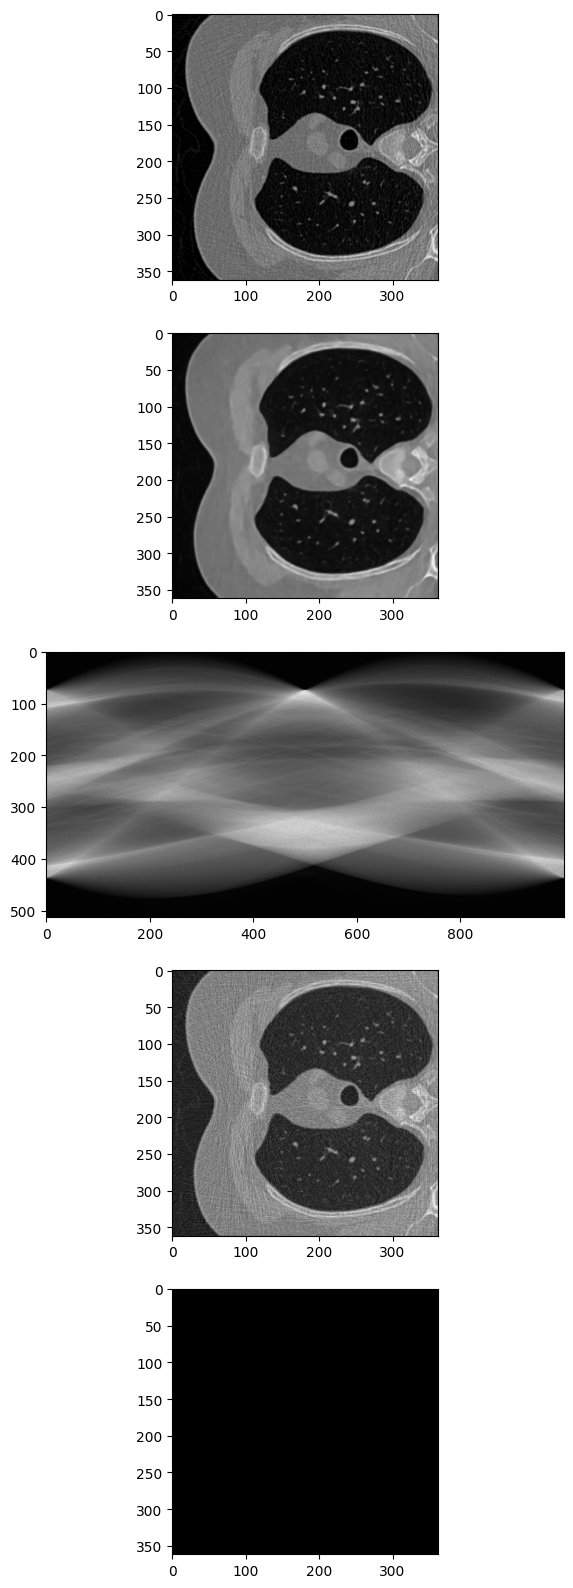

In [ ]:

im = 30
file_number = '000'
show_metrics = True
gttest_path = Path(base_path_win,f'gt_test/ground_truth_test_{file_number}.hdf5')
obtest_path = Path(base_path_win,f'observations_test/observation_test_{file_number}.hdf5')
file_gttest = h5py.File(gttest_path)
file_obtest = h5py.File(obtest_path)
data_gttest = file_gttest['data']
data_obtest = file_obtest['data']
img_obtest = data_obtest[im]

img_gttest = data_gttest[im][:][:]
print(img_gttest.shape)
img_array = np.expand_dims(img_obtest, axis=-1)  # Shape becomes (1000, 513, 1)

# Step 3: Normalize the image if needed (optional, depending on your model's training)
#img_array = img_array / 255.0  # Normalize the image data (if your model expects it)

# Step 4: Add batch dimension (1 image in a batch)
img_array = np.expand_dims(img_array, axis=0)
img_result = model.predict(img_array)
print("IMG RESULT SHAPE", img_result.shape)
img = np.squeeze(img_result)
print(img.shape)

theta = np.linspace(0, 180, 1000, endpoint=False)
# sinogram = radon(img_obtest, theta=theta)
rotated_sin = skimage.transform.rotate(img_obtest, 90, resize=True)

# Perform filtered back projection with a Hann filter
reconstruction_fbp = iradon(rotated_sin, theta=theta, filter_name='ramp', output_size=img_gttest.shape[0], circle=False)
reconstruction_fbp = skimage.transform.rotate(reconstruction_fbp, 90, resize=False)
black = tf.zeros((1, 362, 362, 1))
black_im = tf.squeeze(black)
fig, axs = plt.subplots(5, 1, figsize = (8, 20))
axs[0].imshow(img_gttest, cmap = 'grey')
axs[1].imshow(img, cmap = 'grey')
axs[2].imshow(rotated_sin, cmap = 'grey')
axs[3].imshow(reconstruction_fbp, cmap = 'grey')
axs[4].imshow(black_im, cmap = 'grey')
plt.savefig(f'reconstruct_results_newer/{model_name}.png', format='png')
if show_metrics:
    test_gt_exp = tf.expand_dims(img_gttest, -1)
    test_gt_exp = tf.expand_dims(test_gt_exp, 0)

    test_result = tf.expand_dims(img, 0)

    test_fbp = tf.expand_dims(reconstruction_fbp, 0)
    test_fbp = tf.expand_dims(test_fbp, -1)
    print(test_gt_exp.shape)
    print("OUTPUT IMAGE SHAPE", test_result.shape)
    print(test_fbp.shape)
    # test_gt_exp = tf.expand_dims(test_gt_exp, 1)
    print("PERCEPTUAL LOSS: ")
    print("inferred: ", perceptual_loss(test_gt_exp, img_result))
    print("fbp reconstruction: ",perceptual_loss(test_gt_exp, test_fbp))
    print("ALL BLACK: ",perceptual_loss(test_gt_exp, black))
    print("SSIM LOSS: ")
    print("inferred: ", ssim_loss(test_gt_exp, test_result))
    print("fbp reconstruction: ", ssim_loss(test_gt_exp, test_fbp))
    print("ALL BLACK: ", ssim_loss(test_gt_exp, black))
    print(" ")
    print("GRANDIENT LOSS: ")
    print("inferred: ",gradient_loss(test_gt_exp, test_result))
    print("fbp reconstruction: ",gradient_loss(test_gt_exp, test_fbp))
    print("ALL BLACK: ",gradient_loss(test_gt_exp, black))
    print(" ")
    print("MSE LOSS: ")
    print("inferred: ",tf.reduce_mean(tf.square(test_gt_exp - test_result)))
    print("fbp reconstruction: ",tf.reduce_mean(tf.square(test_gt_exp - test_fbp)))
    print("ALL BLACK: ",tf.reduce_mean(tf.square(test_gt_exp - black)))
    print(" ")
    print("MAE LOSS: ")
    print("inferred: ",tf.reduce_mean(test_gt_exp - test_result))
    print("fbp reconstruction: ",tf.reduce_mean(test_gt_exp - test_fbp))
    print("ALL BLACK: ",tf.reduce_mean(test_gt_exp - black))
    print(" ")
    print("PSNR LOSS: ")
    print("inferred: ",tf.image.psnr(test_gt_exp, test_result, 1))
    print("fbp reconstruction: ",tf.image.psnr(test_gt_exp, test_fbp, 1))
    print("ALL BLACK: ",tf.image.psnr(test_gt_exp, black, 1))
    print(" ")
    print("FOURIER LOSS: ")
    print("inferred: ", frequency_loss(test_gt_exp, test_result))
    print("fbp reconstruction: ", frequency_loss(test_gt_exp, test_fbp))
    print("ALL BLACK: ",frequency_loss(test_gt_exp, black))
    print(" ")
    print(tf.reduce_sum(test_gt_exp))
    print(tf.reduce_sum(test_fbp))
    print("EDGE AWARE LOSS")
    print("inferred: ",edge_aware_loss(test_gt_exp))
    print("fbp reconstruction: ",edge_aware_loss(test_fbp))
    print("ALL BLACK: ",edge_aware_loss(black))
    print("VARIANCE")
    print("inferred: ",variance_regularization_loss(test_gt_exp))
    print("fbp reconstruction: ",variance_regularization_loss(my_bp_image))
    print("ALL BLACK: ",variance_regularization_loss(black))
    print("Add the pixels")
    print("inferred: ",tf.reduce_sum(test_gt_exp))
    print("fbp reconstruction: ",tf.reduce_sum(my_bp_image))
    print("ALL BLACK: ",tf.reduce_sum(black))
    

In [ ]:
fig, axs = plt.subplots(3, 1, figsize = (3, 10))
axs[0].imshow(img_gttest, cmap = 'grey')
axs[1].imshow(img, cmap = 'grey')
axs[2].imshow(img_obtest, cmap = 'grey')


In [ ]:
print(my_bp_image.shape)
my_bp_image = tf.expand_dims(my_bp_image, 0)
bp_show = tf.squeeze(my_bp_image)

(1, 362, 362, 1)


VARIANCE
inferred:  tf.Tensor(-0.013211602, shape=(), dtype=float32)
fbp reconstruction:  tf.Tensor(-3.6913044e-09, shape=(), dtype=float32)
ALL BLACK:  tf.Tensor(-0.0, shape=(), dtype=float32)
Add the pixels
inferred:  tf.Tensor(18544.852, shape=(), dtype=float32)
fbp reconstruction:  tf.Tensor(20.78194, shape=(), dtype=float32)
ALL BLACK:  tf.Tensor(0.0, shape=(), dtype=float32)


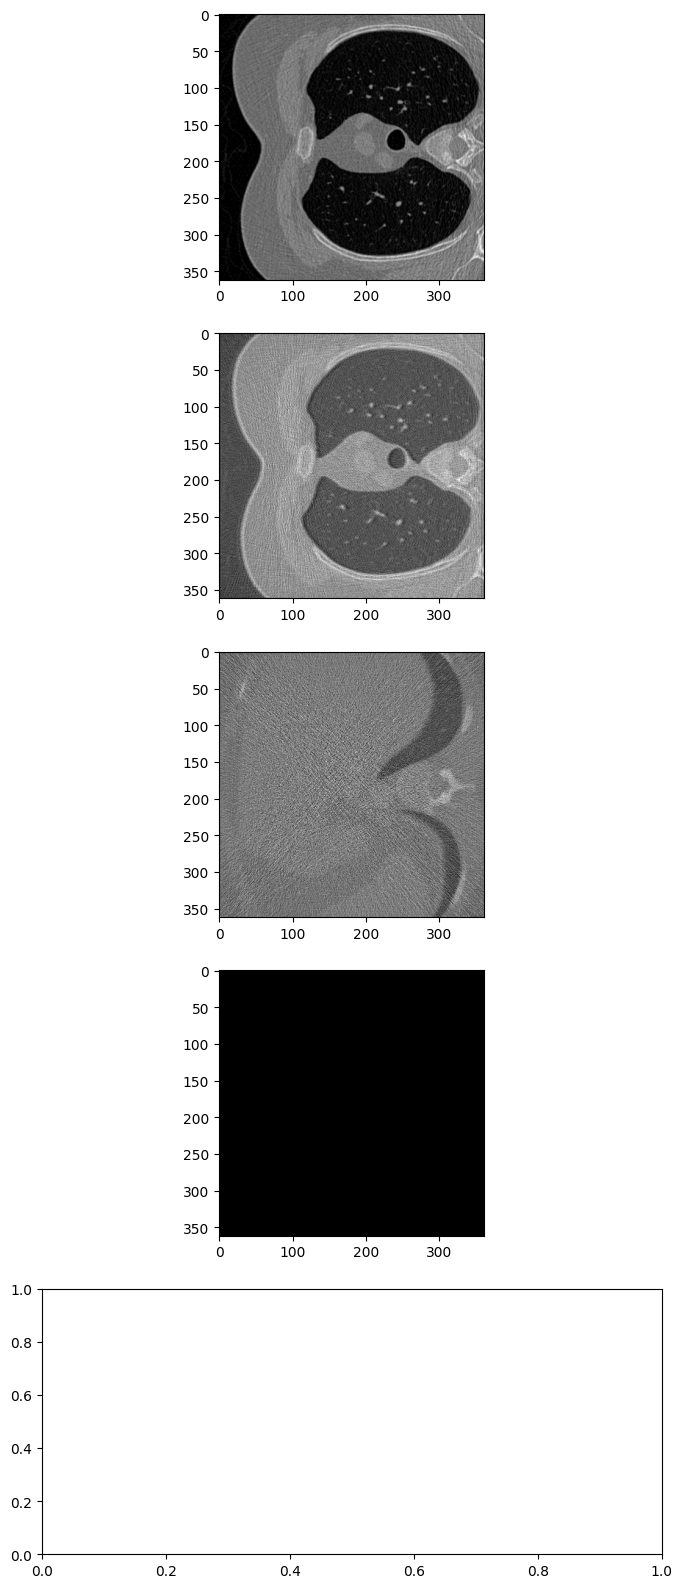

In [ ]:
print("VARIANCE")
print("inferred: ",variance_regularization_loss(test_gt_exp))
print("fbp reconstruction: ",variance_regularization_loss(my_bp_image))
print("ALL BLACK: ",variance_regularization_loss(black))
print("Add the pixels")
print("inferred: ",tf.reduce_sum(test_gt_exp))
print("fbp reconstruction: ",tf.reduce_sum(my_bp_image))
print("ALL BLACK: ",tf.reduce_sum(black))
fig, axs = plt.subplots(5, 1, figsize = (8, 20))
axs[0].imshow(img_gttest, cmap = 'grey')
axs[1].imshow(img, cmap = 'grey')
axs[2].imshow(bp_show, cmap = 'grey')
axs[3].imshow(black_im, cmap = 'grey')

In [ ]:
print(test_fbp)
print(tf.reduce_max(test_fbp))
print(tf.reduce_max(test_gt_exp))

tf.Tensor(
[[[[ 2.7323074e-06]
   [ 1.2241762e-05]
   [ 5.7993702e-06]
   ...
   [ 1.5842447e-04]
   [ 1.5291580e-04]
   [ 1.3815597e-04]]

  [[-2.9279338e-06]
   [ 5.7880679e-06]
   [ 8.8453726e-06]
   ...
   [ 1.6001266e-04]
   [ 1.5831567e-04]
   [ 1.3806132e-04]]

  [[-1.2190047e-06]
   [ 8.6126568e-07]
   [ 8.8552861e-06]
   ...
   [ 1.6431235e-04]
   [ 1.6483723e-04]
   [ 1.4326516e-04]]

  ...

  [[-3.6323895e-06]
   [ 5.1107017e-06]
   [ 3.5575565e-06]
   ...
   [ 1.4113476e-04]
   [ 1.4493038e-04]
   [ 1.3421031e-04]]

  [[ 1.0378655e-05]
   [ 1.3690782e-05]
   [ 8.2366196e-06]
   ...
   [ 1.4766869e-04]
   [ 1.4903277e-04]
   [ 1.3762429e-04]]

  [[ 1.7763679e-05]
   [ 1.7423054e-05]
   [ 1.0106114e-05]
   ...
   [ 1.2684183e-04]
   [ 1.2229534e-04]
   [ 1.1509073e-04]]]], shape=(1, 362, 362, 1), dtype=float32)
tf.Tensor(0.0003367274, shape=(), dtype=float32)
tf.Tensor(0.51956236, shape=(), dtype=float32)


In [ ]:
black = tf.zeros((1, 362, 362, 1))
black


<tf.Tensor: shape=(1, 362, 362, 1), dtype=float32, numpy=
array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]]], dtype=float32)>

In [ ]:
tf.keras.backend.clear_session()